# FlowPlot

> Create beautiful plots of the CRLD flow in phase space

In [ ]:
#| default_exp Utils/FlowPlot

In [ ]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

## Examples

In [ ]:
from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Environments.SocialDilemma import SocialDilemma

from pyCRLD.Utils import FlowPlot as fp

import numpy as np

In [ ]:
env = SocialDilemma(R=1.0, T=0.8, S=-0.5, P=0.0)
mae = stratAC(env=env, learning_rates=0.1, discount_factors=0.9)
x = ([0], [0], [0])
y = ([1], [0], [0])
flowarrow_points = np.linspace(0.01 ,0.99, 9)
standards = [mae, x, y, flowarrow_points]

### Standard quiver flowplot
showing reward-predition error arrows

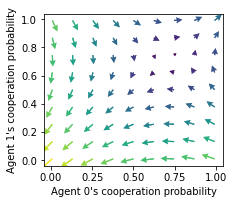

In [ ]:
ax = fp.plot_strategy_flow(*standards)
ax[0].set_xlabel("Agent 0's cooperation probability")
ax[0].set_ylabel("Agent 1's cooperation probability");

### Standard quiver flowplot with trajectory

Trajectory length: 371


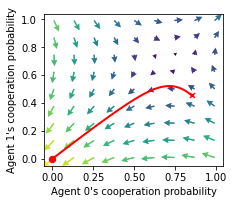

In [ ]:
ax = fp.plot_strategy_flow(*standards)
ax[0].set_xlabel("Agent 0's cooperation probability")
ax[0].set_ylabel("Agent 1's cooperation probability")

X = mae.random_softmax_strategy()
trj, fpr = mae.trajectory(X, Tmax=1000, tolerance=1e-6)
print("Trajectory length:", len(trj))
fp.plot_trajectories([trj], x, y, fprs=[fpr], axes=ax);

### Quiver plot with strategy differences
Notices how the edges of the phase space differ compared to the plots with reward-prediction errors above.

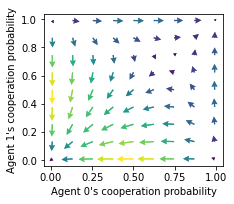

In [ ]:
ax = fp.plot_strategy_flow(*standards, use_RPEarrows=False)
ax[0].set_xlabel("Agent 0's cooperation probability")
ax[0].set_ylabel("Agent 1's cooperation probability");

### Streamplot w RPE
with reward-prediciton errors

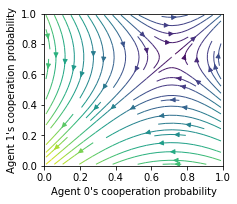

In [ ]:
ax = fp.plot_strategy_flow(*standards, kind="streamplot")
ax[0].set_xlabel("Agent 0's cooperation probability")
ax[0].set_ylabel("Agent 1's cooperation probability");
ax[0].set_xlim(0, 1); ax[0].set_ylim(0, 1);

### Streamplot w dX
with strategy differences

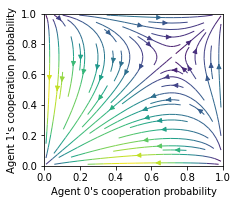

In [ ]:
ax = fp.plot_strategy_flow(*standards, kind="streamplot", use_RPEarrows=False)
ax[0].set_xlabel("Agent 0's cooperation probability")
ax[0].set_ylabel("Agent 1's cooperation probability");
ax[0].set_xlim(0, 1); ax[0].set_ylim(0, 1);

## Core methods

In [ ]:
#| export
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools as it

from collections.abc import Callable

from pyDOE import lhs

from fastcore.utils import *

In [ ]:
#| export
def plot_strategy_flow(mae,  # CRLD multi-agent environment object
                       x:tuple,  # which phase space axes to plot along x axes
                       y:tuple,  # which phase space axes to plot along y axes
                       flowarrow_points,  # specify range & resolution of flow arrows 
                       NrRandom:int=3,  # how many random (in the other dimensions) stratgies for averaging 
                       use_RPEarrows=True,  # Use reward-prediction error arrows?, otherwise use strategy differences
                       col:str='LEN',  # color indicates either strength of flow via colormap, otherwise a fixed color name
                       cmap='viridis',  # Colormap
                       kind='quiver+samples', # Kind of plot: "streamplot", "quiver+samples", "quiver", ...
                       sf=0.5,  # Scale factor for quiver arrows
                       lw=1.0,  # Line width for streamplot
                       dens=0.75,  # Density for streamplot
                       acts=None,  # Action descriptions
                       conds=None,  # Conditions descriptions 
                       axes:Iterable=None,  # Axes to plot into
                       verbose=False,  # shall I talk to you while working?
                       ):  
    """
    Create a flow plot in strategy space.
    """
    # Checks and balances
    xlens, amx, lens = _checks_and_balances(x, y)
    
    # Fig and Axes
    axes = _prepare_axes(axes, xlens)

    # The Plots
    difffunc = _dRPEisa_s if use_RPEarrows else _dXisa_s  # which difference function to use
    for i, (xinds, yinds) in enumerate(zip(it.product(*x), it.product(*y))): # go through each plot sequentially 
        # obtain the data to plot
        X, Y, dX, dY = _data_to_plot(mae, flowarrow_points, xinds, yinds, NrRandom, difffunc,
                                     phasespace_items=_strategies, verbose=verbose)
        # do the plot
        axes[i] = _plot(dX, dY, X, Y, ax=axes[i], sf=sf, kind=kind, lw=lw, dens=dens, col=col, cmap=cmap)

        
    # Decorations
    lens = max(xlens)
    if acts is None:
        acts = [f'act.{i}' for i in range(mae.M)]
        acts = mae.env.Aset
    if conds is None:
        conds = [f'Cond. {i}' for i in range(lens)]
    
    if lens > 1 and amx == 1: # plotting over conditions
        for c, ax in enumerate(axes):
            ax.set_title(conds[c])
            ax.set_xlabel(f"Agnt {x[0][0]+1}'s prob. for {acts[x[0][0]][x[2][0]]}")
            ax.set_ylabel(f"Agnt {y[0][0]+1}'s prob. for {acts[x[0][0]][y[2][0]]}")
            ax.xaxis.labelpad = -8; ax.yaxis.labelpad = -8
            ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    return axes


In [ ]:
#| export
def plot_trajectories(Xtrajs:Iterable,  # Iterable of phase space trajectories 
                      x:tuple,  # which phase space axes to plot along x axes
                      y:tuple,  # which phase space axes to plot along y axes
                      cols:Iterable=["r"],  # Colors to iterate through                      
                      alphas:Iterable=[1.0],  # Alpha values to iterate through
                      lss:Iterable=["-"],  # Linestyles to iterate through
                      lws:Iterable=[2],  # Linewidths to iterate through
                      mss:Iterable=[None],  # Markers to iterate through
                      msss:Iterable=[0],  # Marker sizes to iterate through
                      fprs:Union[Iterable,bool]=None,  # Iteralbe indicating which trajectories reached a fixed point 
                      axes:Iterable=None,  # Axes to plot into
                      submean=False):
    """
    Plot multiple trajectories in phase space. 
    """
    # Checks and balances
    xlens, amx, lens = _checks_and_balances(x, y)
    
    # Fig and Axes
    axes = _prepare_axes(axes, xlens)

    # Fixed point reached?
    if fprs is None:
        fprs = [False for _ in range(len(Xtrajs))]

    # The Plots
    cols = it.cycle(cols); lss = it.cycle(lss); lws = it.cycle(lws);
    mss = it.cycle(mss); msss = it.cycle(msss)
    alphas = it.cycle(alphas);
    for i, (xinds, yinds) in enumerate(zip(it.product(*x), it.product(*y))):
        for j, Xtraj in enumerate(Xtrajs):
            
            Xtraj = Xtraj - Xtraj.mean(-1, keepdims=True) if submean else Xtraj
                
            xs = np.moveaxis(Xtraj, 0, -1)[xinds]
            ys = np.moveaxis(Xtraj, 0, -1)[yinds]
            
            c =  next(cols)
            w = next(lws)
            m = next(mss)
            ms = next(msss)
            alph = next(alphas)
            axes[i].plot(xs, ys, lw=w, ls=next(lss), color=c, alpha=alph,
                         marker=m, markersize=ms)
            
            axes[i].scatter(xs[0], ys[0], color=c, marker='x', s=12*w, alpha=alph)
            if fprs[j]:
                axes[i].scatter(xs[-1], ys[-1], color=c, marker='o', s=20*w,
                                alpha=alph)
            
    return axes

## Helpers

In [ ]:
#| export
def _checks_and_balances(x:tuple,  # which phase space axes to plot along x axes
                         y:tuple   # which phase space axes to plot along y axes
                         ) -> tuple: # (lengths for each dimension, index of dimension to iter, length of iter)
    """Check the format of the `x` and `y` parameter."""
    
    xlens = np.array(list(map(len,x))); ylens = np.array(list(map(len,y)))
    assert sum(xlens == 1) >= 2, "min 2 elements must have length 1"
    assert sum(ylens == 1) >= 2, "min 2 elements must have length 1"
    
    amx = np.argmax(xlens); amy = np.argmax(ylens)
    if amx > 1:
        assert amx == amy, "x and y must have same iter position"
        assert x[amx] == y[amy], "x and y must have same iter position"  
    lens = max(xlens)
    return xlens, amx, lens 

In [ ]:
show_doc(_checks_and_balances)

---

### _checks_and_balances

>      _checks_and_balances (x:tuple, y:tuple)

Check the format of the `x` and `y` parameter.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | tuple | which phase space axes to plot along x axes |
| y | tuple | which phase space axes to plot along y axes |
| **Returns** | **tuple** | **(lengths for each dimension, index of dimension to iter, length of iter)** |

Let's say we want to plot the probability of cooperation of the 0th agent on the $x$ axis and of the 1st agent on the $y$ axis for states 2,3 and 5, we specify (assuming the cooperation is the 0th action)

In [ ]:
x = ([0], [2,3,5], [0])
y = ([1], [2,3,5], [0])
_checks_and_balances(x, y)

(array([1, 3, 1]), 1, 3)

In [ ]:
#| export
def _prepare_axes(axes:Iterable,  # Axes to plot into
                  xlens:tuple  # Lengths for each dimension of `x` and `y`
                 ) -> Iterable:  # of matplotlib axes     
    """
    Check whether `axes` have been provided correctly.
    If `axes` haven't been provided, provide them.
    """
    lens = max(xlens)
    if axes is None:
        fig, axes = plt.subplots(1, lens, figsize=(3.2*lens, 2.8))
        plt.subplots_adjust(wspace=0.4)
    if not hasattr(axes, '__iter__'):
        axes = [axes]
    assert len(axes) == lens, "Number of axes must fit to x and y"
    
    return axes

In [ ]:
show_doc(_prepare_axes)

---

### _prepare_axes

>      _prepare_axes (axes:Iterable, xlens:tuple)

Check whether `axes` have been provided correctly.
If `axes` haven't been provided, provide them.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| axes | typing.Iterable | Axes to plot into |
| xlens | tuple | Lengths for each dimension of `x` and `y` |
| **Returns** | **typing.Iterable** | **of matplotlib axes** |

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

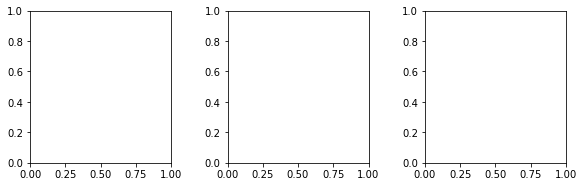

In [ ]:
_prepare_axes(None, [1,3,1])

In [ ]:
#| export
def _dXisa_s(Xisa_s:Iterable, # of joint strategies `Xisa`
            mae  # CRLD multi-agent environment object
            ) -> np.ndarray:  # joint strategy differences 
    """Compute `Xisa`(t-1)-`Xisa`(t) for all `Xisa_s`."""
    return np.array([mae.step(Xisa)[0] - Xisa for Xisa in Xisa_s])

In [ ]:
show_doc(_dXisa_s)

---

### _dXisa_s

>      _dXisa_s (Xisa_s:Iterable, mae)

Compute `Xisa`(t-1)-`Xisa`(t) for all `Xisa_s`.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| Xisa_s | typing.Iterable | of joint strategies `Xisa` |
| mae |  | MARLDynamics multi-agent environment object |
| **Returns** | **ndarray** | **joint strategy differences** |

In [ ]:
from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Environments.SocialDilemma import SocialDilemma

In [ ]:
env = SocialDilemma(R=1.0, T=0.8, S=-0.5, P=0.0)
mae = stratAC(env=env, learning_rates=0.1, discount_factors=0.9)

Xisa_s = [mae.random_softmax_strategy() for _ in range(7)]
_dXisa_s(Xisa_s, mae).shape

(7, 2, 1, 2)

In [ ]:
#| export
def _dRPEisa_s(Xisa_s:Iterable, # of joint strategies `Xisa`
              mae  # CRLD multi-agent environment object
            ) -> np.ndarray:  # joint reward-prediction errors
    """Compute reward-prediction errors `RPEisa_s` for Xs."""
    return np.array([mae.RPEisa(Xisa, norm=True) for Xisa in Xisa_s])

In [ ]:
show_doc(_dRPEisa_s)

---

### _dRPEisa_s

>      _dRPEisa_s (Xisa_s:Iterable, mae)

Compute reward-prediction errors `RPEisa_s` for Xs.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| Xisa_s | typing.Iterable | of joint strategies `Xisa` |
| mae |  | MARLDynamics multi-agent environment object |
| **Returns** | **ndarray** | **joint reward-prediction errors** |

In [ ]:
env = SocialDilemma(R=1.0, T=0.8, S=-0.5, P=0.0)
mae = stratAC(env=env, learning_rates=0.1, discount_factors=0.9)

Xisa_s = [mae.random_softmax_strategy() for _ in range(7)]
_dRPEisa_s(Xisa_s, mae).shape

(7, 2, 1, 2)

In [ ]:
#| export
def _strategies(mae,  # CRLD multi-agent environment object
                xinds:tuple,  # of indices of the phase space item to plot along the x axis
                yinds:tuple,  # of indices of the phase space item to plot along the y axis
                xval:float,  # the value of the phase space item to plot along the x axis
                yval:float,  # the value of the phase space item to plot along the y axis
                NrRandom,  # how many random (in the other dimensions) stratgies for averaging
               ) -> np.ndarray: # Array of joint strategies
    """
    Creates strategies (as a particular type of phase space item) for one ax plot point.
    All strategies have value `xval` at the `xinds` index and value `yval` at the `yinds`. 
    """   
    N, C, M = mae.N, mae.Q, mae.M  # Number of agents, conditions, actions
    # Xs = np.random.rand(NrRandom, N, C, M)  # random policies
    Xs = lhs(N*C*M, NrRandom).reshape(NrRandom, N, C, M)  # using latin hypercube sampling
    Xs = Xs / Xs.sum(axis=-1, keepdims=True)  # properly normalised
    
    xi, xc, xa = xinds; xa_ = tuple(set(range(M)) - set([xa]))
    yi, yc, ya = yinds; ya_ = tuple(set(range(M)) - set([ya]))
    
    Xs[:, xi, xc, xa] = xval  # setting x and y values
    Xs[:, yi, yc, ya] = yval
    
    # normalisation
    Xs[:,xi,xc,xa_] = (1-Xs[0, xi, xc, xa]) * Xs[:,xi,xc,xa_]\
        / np.sum(Xs[:,xi,xc,xa_], axis=-1, keepdims=True)
    Xs[:,yi,yc,ya_] = (1-Xs[0, yi, yc, ya]) * Xs[:,yi,yc,ya_]\
        / np.sum(Xs[:,yi,yc,ya_], axis=-1, keepdims=True)
    
    return Xs

In [ ]:
show_doc(_strategies)

---

### _strategies

>      _strategies (mae, xinds:tuple, yinds:tuple, xval:float, yval:float,
>                   NrRandom)

Creates strategies (as a particular type of phase space item) for one ax plot point.
All strategies have value `xval` at the `xinds` index and value `yval` at the `yinds`.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| mae |  | MARLDynamics multi-agent environment object |
| xinds | tuple | of indices of the phase space item to plot along the x axis |
| yinds | tuple | of indices of the phase space item to plot along the y axis |
| xval | float | the value of the phase space item to plot along the x axis |
| yval | float | the value of the phase space item to plot along the y axis |
| NrRandom |  | how many random (in the other dimensions) stratgies for averaging |
| **Returns** | **ndarray** | **Array of joint strategies** |

For example, given

In [ ]:
env = SocialDilemma(R=1.0, T=0.8, S=-0.5, P=0.0)
mae = stratAC(env=env, learning_rates=0.1, discount_factors=0.9)

the following parameters give

In [ ]:
xinds = (0, 0, 0)  # Plot agent 0's state-action item 0, 0
yinds = (1, 0, 0)  # Plot agent 1's state-action item 0, 0
NrRandom = 3

strats = _strategies(mae, xinds, yinds, xval=0.2, yval=0.4, NrRandom=NrRandom)
assert strats.shape[0] == NrRandom
strats.shape

(3, 2, 1, 2)

The first dimension of the `_strategies` return holds the randomization in the other dimensions than given by `xinds` and `yinds`.
Note that the randomization in the other dimensions makes no sense in a stateless normal-form game since there are no other dimensions.

In [ ]:
#| export
def _data_to_plot(mae,  # CRLD multi-agent environment object
                  flowarrow_points:Iterable,  # range & resolution of flow arrows 
                  xinds:tuple,  # of indices of the phase space object to plot along the x axis
                  yinds:tuple,  # of indices of the phase space object to plot along the y axis
                  NrRandom:int,  # how many random (in the other dimensions) stratgies for averaging 
                  difffunc:Callable,  # to compute which kind of arrows to plot (RPE or dX)
                  phasespace_items:Callable,  # to obtain phase space items for one ax plot point
                  verbose=False  # shall I talk to you while working?
                 ) -> tuple:  # meshgrid for (X, Y, dX, dY)
        
    l = len(flowarrow_points)
    X, Y = np.meshgrid(flowarrow_points, flowarrow_points)
    dX, dY = np.zeros((l, l, NrRandom)), np.zeros((l, l, NrRandom))

    for i, xval in enumerate(flowarrow_points):
        for j, yval in enumerate(flowarrow_points):
            if verbose:
                print("\r [plot] generating data",
                      str(np.round((i*l+j)/l**2,2)*100)[:2], "%", end="   ")
            
            psi_s = phasespace_items(mae, xinds=xinds, yinds=yinds, xval=xval, yval=yval,
                                     NrRandom=NrRandom)
                        
            dpsi_s = difffunc(psi_s, mae)
            dX[j, i] = np.moveaxis(dpsi_s, 0, -1)[xinds]
            dY[j, i] = np.moveaxis(dpsi_s, 0, -1)[yinds]
            
    return X, Y, dX, dY

In [ ]:
show_doc(_data_to_plot)

---

### _data_to_plot

>      _data_to_plot (mae, flowarrow_points:Iterable, xinds:tuple, yinds:tuple,
>                     NrRandom:int, difffunc:collections.abc.Callable,
>                     phasespace_items:collections.abc.Callable, verbose=False)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| mae |  |  | MARLDynamics multi-agent environment object |
| flowarrow_points | typing.Iterable |  | range & resolution of flow arrows |
| xinds | tuple |  | of indices of the phase space object to plot along the x axis |
| yinds | tuple |  | of indices of the phase space object to plot along the y axis |
| NrRandom | int |  | how many random (in the other dimensions) stratgies for averaging |
| difffunc | Callable |  | to compute which kind of arrows to plot (RPE or dX) |
| phasespace_items | Callable |  | to obtain phase space items for one ax plot point |
| verbose | bool | False | shall I talk to you while working? |
| **Returns** | **tuple** |  | **meshgrid for (X, Y, dX, dY)** |

For example, given

In [ ]:
env = SocialDilemma(R=1.0, T=0.8, S=-0.5, P=0.0)
mae = stratAC(env=env, learning_rates=0.1, discount_factors=0.9)

the following parameters give

In [ ]:
xinds = (0, 0, 0)  # Plot agent 0's state-action item 0, 0
yinds = (1, 0, 0)  # Plot agent 1's state-action item 0, 0
flowarrow_points = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
NrRandom=7
difffunc = _dRPEisa_s
phasespace_items = _strategies
verbose = True

X, Y, dX, dY = _data_to_plot(mae, flowarrow_points, xinds, yinds, NrRandom, difffunc,
                             phasespace_items=_strategies, verbose=verbose)

assert X.shape == Y.shape; print("\nShape of `X` and `Y`:", X.shape)
assert dX.shape == dY.shape; print("Shape of `dX` and `dY`:", dX.shape)
assert dX.shape[-1] == NrRandom

 [plot] generating data 96 %   
Shape of `X` and `Y`: (5, 5)
Shape of `dX` and `dY`: (5, 5, 7)


Let $l$ be the number  of the `flowarrow_points`, than `X` and `Y` have shape of ($l$, $l$). 
`dX` and `dY` have shape of ($l$, $l$, Number of randomizations). 

In [ ]:
#| export
def _plot(dX:np.ndarray,  # differences in x dimension
          dY:np.ndarray,  # differences in y dimension
          X:np.ndarray,  # meshgrid in x dimension
          Y:np.ndarray,  # meshgrid in y dimension
          ax=None,  # Individual axis to plot into
          sf=1.0,  # Scale factor for quiver arrows
          col='LEN', # what should the color indicatie
          cmap="viridis",  # Colormap
          kind='quiver+samples',  # Kind of plot: "quiver", "quiver+samples", "quiver", ...
          lw=1.0,  # Line width
          dens=0.75):  # Density
    """
    Plots the flow for one condition into one axes
    """
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(4,4))
        
    if kind == "streamplot":
        DX = dX.mean(axis=-1)
        DY = dY.mean(axis=-1)
        LEN = (DX**2 + DY**2)**0.5
        col = LEN if col=="LEN" else col
        ax.streamplot(X, Y, DX, DY, color=LEN, linewidth=lw, cmap=cmap,
                      density=dens)
        
    elif kind.startswith('quiver'):
        qkwargs = {"units":"xy", "angles": "xy", "scale":None, # quiver parameters
                   "scale_units": "xy", "headwidth": 5, "pivot": "tail"}
    
        if kind.endswith('samples'):  # plot inidividual samples
            Nr = dX.shape[-1]
            for i in range(Nr):
                DX = dX[:, :, i]
                DY = dY[:, :, i]
                
                if col == "LEN":
                    LEN = (DX**2 + DY**2)**0.5 
                    ax.quiver(X, Y, *_scale(DX, DY, sf), LEN, alpha=1/Nr, cmap=cmap, **qkwargs)
                else:
                    ax.quiver(X, Y, *_scale(DX, DY, sf), alpha=1/Nr, color=col, **qkwargs) 

        DX = dX.mean(axis=-1)
        DY = dY.mean(axis=-1)
        if col == "LEN":
            LEN = (DX**2 + DY**2)**0.5
            ax.quiver(X, Y, *_scale(DX, DY, sf), LEN, cmap=cmap, **qkwargs)
        else:
            ax.quiver(X, Y, *_scale(DX, DY, sf), color=col, **qkwargs)        
    return ax

In [ ]:
show_doc(_plot)

---

### _plot

>      _plot (dX:numpy.ndarray, dY:numpy.ndarray, X:numpy.ndarray,
>             Y:numpy.ndarray, ax=None, sf=1.0, col='LEN', cmap='viridis',
>             kind='quiver+samples', lw=1.0, dens=0.75)

Plots the flow for one condition into one axes

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dX | ndarray |  | differences in x dimension |
| dY | ndarray |  | differences in y dimension |
| X | ndarray |  | meshgrid in x dimension |
| Y | ndarray |  | meshgrid in y dimension |
| ax | NoneType | None | Individual axis to plot into |
| sf | float | 1.0 | Scale factor for quiver arrows |
| col | str | LEN | what should the color indicatie |
| cmap | str | viridis | Colormap |
| kind | str | quiver+samples | Kind of plot: "quiver", "quiver+samples", "quiver", ... |
| lw | float | 1.0 | Line width |
| dens | float | 0.75 | Density |

In [ ]:
#| export
def _scale(x:float,   # x dimension 
           y:float,   # y dimension
           a:float    # scaling factor
          )-> tuple:  # scaled (x,y)
    
    """
    Scales length of the (`x`, `y`) vector accoring to length to the power of `a`.
    """
    l = (x**2 + y**2)**(1/2)
    l = l + (l==0)
    k = l**a
    return k/l * x, k/l * y

In [ ]:
show_doc(_scale)

---

### _scale

>      _scale (x:float, y:float, a:float)

Scales length of the (`x`, `y`) vector accoring to length to the power of `a`.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | float | x dimension |
| y | float | y dimension |
| a | float | scaling factor |
| **Returns** | **tuple** | **scaled (x,y)** |

A scale factor of `0` makes all vectors equally large.

In [ ]:
_scale(4, 3, 0)

(0.8, 0.6000000000000001)

In [ ]:
_scale(40, 30, 0)

(0.8, 0.6)

A scale factor of `1` does not change a vector's length

In [ ]:
_scale(4, 3, 1)

(4.0, 3.0)

In [ ]:
_scale(40, 30, 1)

(40.0, 30.0)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()